In [1]:
import datetime
import glob
import numpy as np
import pandas as pd

from utils_plotting import plot_spread_analysis

In [2]:
csv_files = glob.glob('./data/spy-*-cleaned.csv')
dfs = []

for file in csv_files:
    print(f'appending data from {file}')
    df = pd.read_csv(file)
    dfs.append(df)

appending data from ./data/spy-2025-07-07-cleaned.csv


In [3]:
combined_df = pd.concat(dfs, ignore_index=True)

In [4]:
# See https://docs.python.org/3/library/datetime.html
# The hour is not zero padded, so %-I
combined_df['DateTime'] = pd.to_datetime(
    combined_df['Date'] + ' ' + combined_df['Time'],
    format='%m/%d/%Y %I:%M %p',
)

In [5]:
# Remove duplicates keeping the first occurrence.
clean_df = combined_df.drop_duplicates(subset=['DateTime'], keep='first')

# Sort by timestamp to ensure proper chronological order.
clean_df = clean_df.sort_values('DateTime').reset_index(drop=True)

In [6]:
clean_df.to_csv('./data/spy_combined_price_data.csv', index=False)

In [7]:
df = pd.read_csv('./data/spy_combined_price_data.csv')

df['DateTime'] = pd.to_datetime(df['DateTime'])

In [8]:
df.tail(1)

,Date,Time,Open,High,Low,Close,Volume,Simple Moving Average - SMA - SMA(20),Simple Moving Average - SMA - SMA(50),Simple Moving Average - SMA - SMA(200),"Exponential Moving Average - EMA - EMA(9,Modern)","Exponential Moving Average - EMA - EMA(61,Modern)",Relative Strength Index - RSI - RSI(14),"MACD - MACD(12,26,9)",MACD - Histogram,"MACD - Signal Line(MACD(12,26,9),9,Modern)",DateTime
2534,07/07/2025,8:00 PM,619.9799,620.0,619.9799,620.0,626,619.890105,619.825082,619.588439,619.935433,619.763928,57.707894,0.038955,0.001371,0.037584,2025-07-07 20:00:00


In [9]:
df['DateTime'].iloc[0]

Timestamp('2025-07-01 16:00:00')

In [10]:
np.flip( df['DateTime'].dt.date.unique() )

array([datetime.date(2025, 7, 7), datetime.date(2025, 7, 3),
       datetime.date(2025, 7, 2), datetime.date(2025, 7, 1)], dtype=object)

using 2025-07-03 as previous date
prev day close: 625.01
price at close: 620.0
first time: 2025-07-07 04:01:00, last time: 2025-07-07 20:00:00
closest time index for 09:30:00 on 2025-07-07: 264
closest time index for 09:45:00 on 2025-07-07: 279
closest time index for 15:00:00 on 2025-07-07: 594


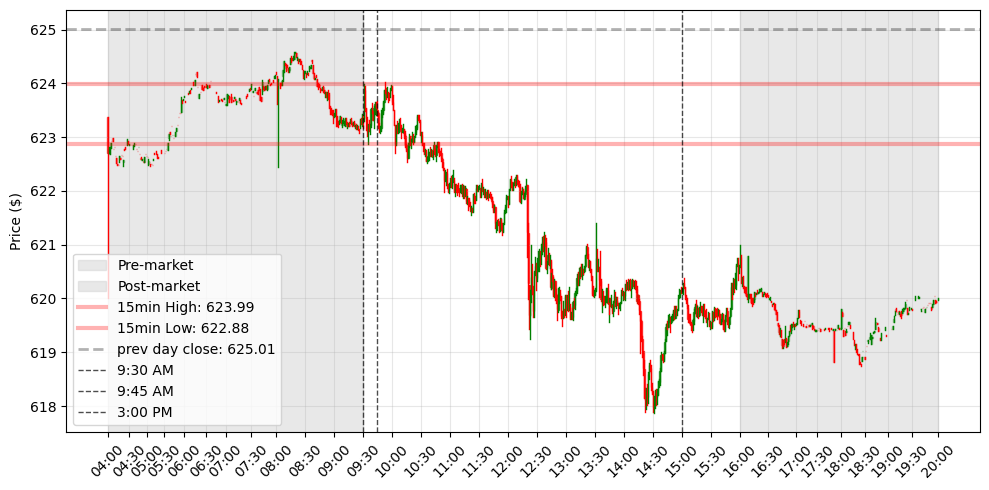

In [11]:
plot_spread_analysis(df, datetime.date(2025, 7, 7))

In [12]:
df[df['DateTime'].dt.date == datetime.date(2025, 7, 7)].iloc[593:596]

,Date,Time,Open,High,Low,Close,Volume,Simple Moving Average - SMA - SMA(20),Simple Moving Average - SMA - SMA(50),Simple Moving Average - SMA - SMA(200),"Exponential Moving Average - EMA - EMA(9,Modern)","Exponential Moving Average - EMA - EMA(61,Modern)",Relative Strength Index - RSI - RSI(14),"MACD - MACD(12,26,9)",MACD - Histogram,"MACD - Signal Line(MACD(12,26,9),9,Modern)",DateTime
2268,07/07/2025,2:59 PM,620.1350,620.2199,620.10,620.1307,89424,619.63642,619.188924,620.296087,619.919389,619.486016,71.850318,0.282478,0.049185,0.233293,2025-07-07 14:59:00
2269,07/07/2025,3:00 PM,620.1301,620.2000,620.10,620.1600,66067,619.70142,619.185924,620.287212,619.967511,619.507757,72.449863,0.287363,0.043256,0.244107,2025-07-07 15:00:00
2270,07/07/2025,3:01 PM,620.1500,620.2900,620.08,620.2700,137958,619.76592,619.186424,620.279062,620.028009,619.532346,74.634142,0.296690,0.042066,0.254624,2025-07-07 15:01:00


using 2025-07-02 as previous date
prev day close: 620.62
price at close: 625.01
first time: 2025-07-03 04:01:00, last time: 2025-07-03 17:00:00
closest time index for 09:30:00 on 2025-07-03: 254
closest time index for 09:45:00 on 2025-07-03: 269
closest time index for 15:00:00 on 2025-07-03: 582


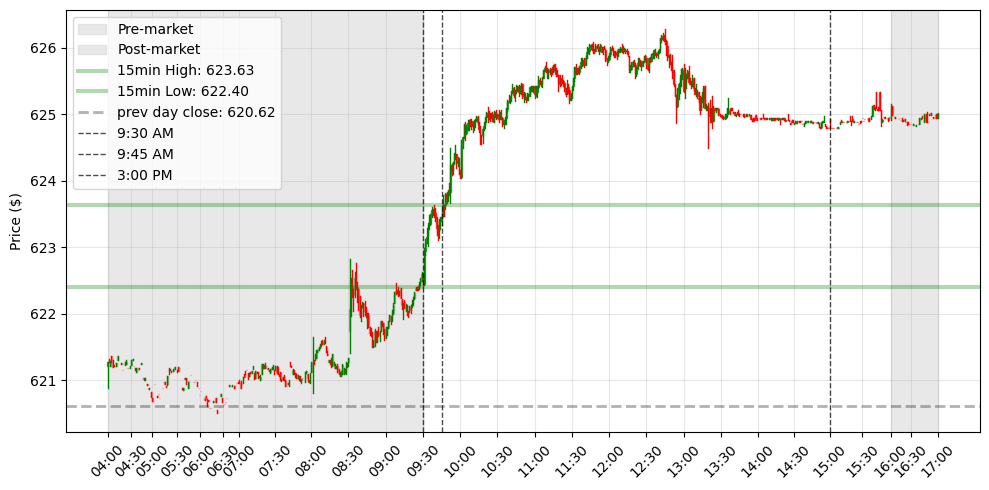

In [13]:
plot_spread_analysis(df, datetime.date(2025, 7, 3))

In [14]:
df[df['DateTime'].dt.date == datetime.date(2025, 7, 3)].iloc[581:584]

,Date,Time,Open,High,Low,Close,Volume,Simple Moving Average - SMA - SMA(20),Simple Moving Average - SMA - SMA(50),Simple Moving Average - SMA - SMA(200),"Exponential Moving Average - EMA - EMA(9,Modern)","Exponential Moving Average - EMA - EMA(61,Modern)",Relative Strength Index - RSI - RSI(14),"MACD - MACD(12,26,9)",MACD - Histogram,"MACD - Signal Line(MACD(12,26,9),9,Modern)",DateTime
1586,07/03/2025,2:59 PM,624.79,624.80,624.79,624.79,1813,624.864465,624.893158,625.353659,624.831469,624.919283,36.079407,-0.023389,-0.006845,-0.016544,2025-07-03 14:59:00
1587,07/03/2025,3:00 PM,624.81,624.93,624.80,624.80,653,624.859465,624.890358,625.348709,624.825175,624.915435,38.387499,-0.024815,-0.006617,-0.018198,2025-07-03 15:00:00
1588,07/03/2025,3:01 PM,624.79,624.79,624.79,624.79,1682,624.853970,624.887158,625.343859,624.818140,624.911389,36.950625,-0.026448,-0.006600,-0.019848,2025-07-03 15:01:00


using 2025-07-01 as previous date
prev day close: 617.929
price at close: 620.62
first time: 2025-07-02 04:01:00, last time: 2025-07-02 20:01:00
closest time index for 09:30:00 on 2025-07-02: 266
closest time index for 09:45:00 on 2025-07-02: 281
closest time index for 15:00:00 on 2025-07-02: 596


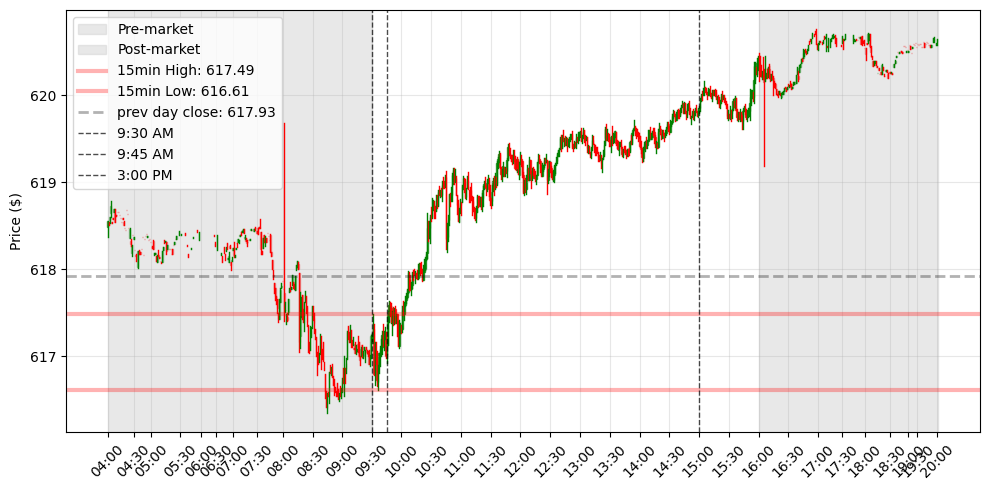

In [15]:
plot_spread_analysis(df, datetime.date(2025, 7, 2))